# Setup

In [85]:
!rm *.csv # Removendo dados anteriores
!rm -R figs # Removendo pasta de figuras
!rm -R tabs # Removendo pasta de tabelas
!mkdir figs # Criando pasta para salvar figuras
!mkdir tabs # Criando pasta para salvar tabelas
!ls

rm: não foi possível remover '*.csv': Arquivo ou diretório inexistente
Benchmanrk.ipynb  Clean.ipynb  figs  tabs


# Introdução

Esta rotina ajusta um modelo de séries temporais. 
Será testado se o investimento residencial ($I_h$) depende da <u>taxa própria de juros</u> dos imóveis, ou seja,

$$
I_h = f(r_{mo}, p_h)
$$
em que

- $I_h$ Investimento residencial

  + **Série:** PRFI
  + Com ajuste sazonal
  + Trimestral
  
- $r_{mo}$ taxa de juros das hipotecas
  + **Série:** MORTGAGE30US
  - Sem ajuste sazonal
  - Semanal (encerrado às quintas feiras)

- $p_h$ Inflação de imóveis: Índice Case-Shiller

  + **Série:** CSUSHPISA
  + Com ajuste sazonal, Jan 2000 = 100
  + Mensal
  
**Nota:** Uma vez que pretende-se utilizar os resultados obtidos deste modelo em um trabalho futuro, os resultados serão checados tanto em python quanto em gretl, ambos softwares livres.

# Carregando pacotes

In [90]:
%config InlineBackend.figure_format = 'retina'

# Pacotes gerais

import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import datetime

# Pacotes estatísticos

from statsmodels.tsa.vector_ar.var_model import VAR
from statsmodels.tsa.api import SVAR
from statsmodels.tsa.vector_ar.vecm import coint_johansen, CointRankResults, VECM

from statsmodels.stats.diagnostic import acorr_breusch_godfrey, acorr_ljungbox, het_arch, het_breuschpagan, het_white
from statsmodels.tsa.stattools import adfuller, kpss, grangercausalitytests, q_stat, coint
from arch.unitroot import PhillipsPerron, ZivotAndrews, DFGLS, KPSS, ADF

from statsmodels.graphics.tsaplots import plot_acf, plot_pacf

# Pacotes para importação de dados

import pandas_datareader.data as web
from scipy.stats import yeojohnson

# Configurações do notebook

plt.style.use('seaborn-white')
start = datetime.datetime(1987, 1, 1)
end = datetime.datetime(2019, 1, 1)

# Importando dados

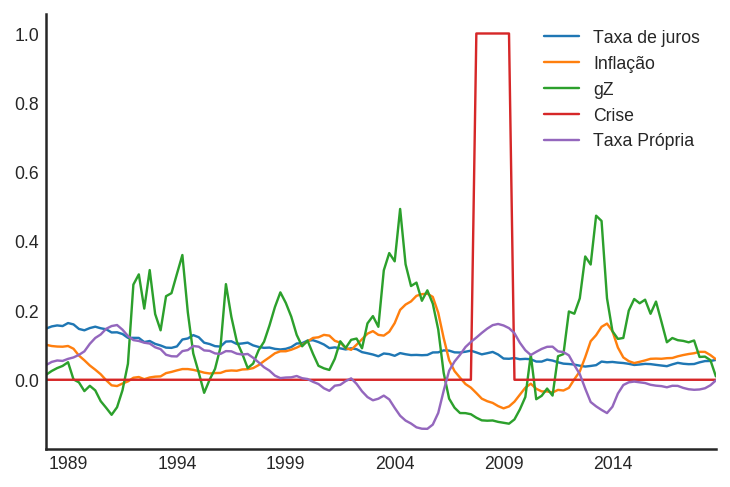

In [91]:
df = web.DataReader(
    [
        "PRFI",
        "CSUSHPISA",
        "MORTGAGE30US",
    ], 
    'fred', 
    start, 
    end
)

df.columns = [
    "Investimento residencial", 
    "Preço dos imóveis", 
    "Taxa de juros",
]

df.index.name = ""
df['Taxa de juros'] = df['Taxa de juros'].divide(100)
df = df.resample('Q').mean()
df['Preço dos imóveis'] = df['Preço dos imóveis']*df['Preço dos imóveis']["1999-12-31"]/df['Preço dos imóveis'][0]/100
df["Inflação"], *_ = yeojohnson(df["Preço dos imóveis"].pct_change(4))
df['gZ'], *_ = yeojohnson(df["Investimento residencial"].pct_change(4))
df["Taxa de juros"], *_ = yeojohnson(df["Taxa de juros"])
df["Taxa Própria"] = ((1+df["Taxa de juros"])/(1+df["Inflação"])) -1

df["Crise"] = [0 for i in range(len(df["gZ"]))]
for i in range(len(df["Crise"])):
    if df.index[i] > datetime.datetime(2007,12,1) and df.index[i] < datetime.datetime(2009,7,1):
        df["Crise"][i] = 1

df.to_csv("Dados_yeojohnson.csv", )

df = df[["Taxa de juros", "Inflação", "gZ", "Crise", "Taxa Própria"]]
        
df = df.dropna()
df.plot()
sns.despine()
plt.show()

# Teste de cointegração

## Engel-granger

In [92]:
def cointegracao(ts0, ts1, trend = 'c', signif = 0.05):
  result = coint(ts0, ts1, trend = trend, autolag='bic')
  print('Null Hypothesis: there is NO cointegration')
  print('Alternative Hypothesis: there IS cointegration')
  print('t Statistic: %f' % result[0])
  print('p-value: %f' % result[1])
  if result[1] < signif:
    print('REJECT null Hypothesis: there IS cointegration')
  else:
    print('FAIL to reject Null Hypothesis: there is NO cointegration')

In [93]:
cointegracao(ts0 = df['gZ'], ts1 = df[['Inflação']])

Null Hypothesis: there is NO cointegration
Alternative Hypothesis: there IS cointegration
t Statistic: -2.700328
p-value: 0.199461
FAIL to reject Null Hypothesis: there is NO cointegration


In [94]:
cointegracao(ts0 = df['gZ'], ts1 = df[['Inflação', 'Taxa de juros']])

Null Hypothesis: there is NO cointegration
Alternative Hypothesis: there IS cointegration
t Statistic: -2.479682
p-value: 0.494677
FAIL to reject Null Hypothesis: there is NO cointegration


In [104]:
cointegracao(ts0 = df['gZ'], ts1 = df[['Taxa Própria']])

Null Hypothesis: there is NO cointegration
Alternative Hypothesis: there IS cointegration
t Statistic: -2.462145
p-value: 0.296014
FAIL to reject Null Hypothesis: there is NO cointegration


### Conclusão    
    
Adotando um valor crítico de 5%, não rejeita-se a hipótese nula para as variáveis individuais e para os resíduos. Portanto, não há evidências de relação de cointegração sem a inclusão dos juros. As conclusões são as mesmas com a inclusão dos juros. Portanto, a partir do teste de Engel-Granger, conclui-se que não existe relação de cointegração entre as variáveis.

## Johansen

O teste de Engel-Granger não capta cointegração conjunta entre as variáveis e, portanto, deve ser utilizado o teste de Johansen. **OBS:** Dada a importância das implicações dos resultados deste teste, será adotado um nível de significância mais "rigoroso" de 1%. Testando sucessivamente começando em r = 1 (max. = 3).

### Python

In [105]:
def johansen(ts, det_order = 1, k_ar_diff = 2, signif = 0.05):
  """
  ts = ts dataframe
  det_order = similar to coint_johansen function
    - (-1): no deterministic terms
    - 0: constant term
    - 1: linear trend
  k_ar_diff = similar to coint_johansen function
  signif = 0.1, 0.05, 0.01
  """
  var = len(ts.columns)
  result = coint_johansen(
      endog = ts, 
      det_order = det_order,
      k_ar_diff = k_ar_diff
  )

  p = [i for i in range(var)]
  
  print("Null hypothesis: number of cointegration vectors is r* = {}".format(k_ar_diff))
  print('Alternative (Trace): r* > {}'.format(k_ar_diff))
  print('\n')
  for i in range(var):
    print("Test for variable " + str(ts.columns[i]).upper())
    print("TRACE test")
    print('Statistic: %f' % result.lr1[i])
    print('Critical Values:')
    print('\t 10%: ', result.cvt[i][0])
    print('\t 5%: ', result.cvt[i][1])
    print('\t 1%: ', result.cvt[i][2])
    
    if signif == 0.05:
      p[i] = result.cvt[i][1]
    elif signif == 0.01:
      p[i] = result.cvt[i][2]
    else:
      p[i] = result.cvt[i][0]
      
  print("For a significant level of {}, REJECT null hypothesis? {}".format(signif, np.sum(result.lr1 > p) == var))

Incluindo taxa de juros dos imóveis.

In [106]:
johansen(df[['Taxa de juros', 'Inflação', 'gZ']], det_order = 1, k_ar_diff = 0, signif = 0.01)

Null hypothesis: number of cointegration vectors is r* = 0
Alternative (Trace): r* > 0


Test for variable TAXA DE JUROS
TRACE test
Statistic: 102.641172
Critical Values:
	 10%:  32.0645
	 5%:  35.0116
	 1%:  41.0815
Test for variable INFLAÇÃO
TRACE test
Statistic: 44.943513
Critical Values:
	 10%:  16.1619
	 5%:  18.3985
	 1%:  23.1485
Test for variable GZ
TRACE test
Statistic: 6.580712
Critical Values:
	 10%:  2.7055
	 5%:  3.8415
	 1%:  6.6349
For a significant level of 0.01, REJECT null hypothesis? False


In [107]:
johansen(df[['Taxa de juros', 'Inflação', 'gZ']], det_order = 1, k_ar_diff = 1, signif = 0.01)

Null hypothesis: number of cointegration vectors is r* = 1
Alternative (Trace): r* > 1


Test for variable TAXA DE JUROS
TRACE test
Statistic: 51.521904
Critical Values:
	 10%:  32.0645
	 5%:  35.0116
	 1%:  41.0815
Test for variable INFLAÇÃO
TRACE test
Statistic: 26.954884
Critical Values:
	 10%:  16.1619
	 5%:  18.3985
	 1%:  23.1485
Test for variable GZ
TRACE test
Statistic: 12.056876
Critical Values:
	 10%:  2.7055
	 5%:  3.8415
	 1%:  6.6349
For a significant level of 0.01, REJECT null hypothesis? True


In [108]:
johansen(df[['Taxa de juros', 'Inflação', 'gZ']], det_order = 1, k_ar_diff = 2, signif = 0.01)

Null hypothesis: number of cointegration vectors is r* = 2
Alternative (Trace): r* > 2


Test for variable TAXA DE JUROS
TRACE test
Statistic: 42.877391
Critical Values:
	 10%:  32.0645
	 5%:  35.0116
	 1%:  41.0815
Test for variable INFLAÇÃO
TRACE test
Statistic: 20.961551
Critical Values:
	 10%:  16.1619
	 5%:  18.3985
	 1%:  23.1485
Test for variable GZ
TRACE test
Statistic: 8.051458
Critical Values:
	 10%:  2.7055
	 5%:  3.8415
	 1%:  6.6349
For a significant level of 0.01, REJECT null hypothesis? False


**Conclusão:** A hipótese nula do teste não é rejeitada a um nível de significância de 1% para $r\geq 2$. Portanto, há envidências de relação de cointegração entre as variávies.

REVISAR

Testando sem os juros (determinado exogenamente).

In [109]:
johansen(df[['Inflação', 'gZ']], det_order = 1, k_ar_diff = 0, signif = 0.01)

Null hypothesis: number of cointegration vectors is r* = 0
Alternative (Trace): r* > 0


Test for variable INFLAÇÃO
TRACE test
Statistic: 53.411260
Critical Values:
	 10%:  16.1619
	 5%:  18.3985
	 1%:  23.1485
Test for variable GZ
TRACE test
Statistic: 6.071659
Critical Values:
	 10%:  2.7055
	 5%:  3.8415
	 1%:  6.6349
For a significant level of 0.01, REJECT null hypothesis? False


In [110]:
johansen(df[['Inflação', 'gZ']], det_order = 1, k_ar_diff = 1, signif = 0.01)

Null hypothesis: number of cointegration vectors is r* = 1
Alternative (Trace): r* > 1


Test for variable INFLAÇÃO
TRACE test
Statistic: 27.747761
Critical Values:
	 10%:  16.1619
	 5%:  18.3985
	 1%:  23.1485
Test for variable GZ
TRACE test
Statistic: 13.459240
Critical Values:
	 10%:  2.7055
	 5%:  3.8415
	 1%:  6.6349
For a significant level of 0.01, REJECT null hypothesis? True


Excluindo os juros (teoricamente mais factível), não há evidências de relação de cointegração a 1%.

### Conclusão 

Não é possível não rejeitar a hipótese nula tanto para o teste do traço quanto para o teste autovalor máximo. Portanto, conclui-se que as série não são estácionários mas **não** apresentam relação de correlação.

# Teste de raíz unitária

## Investimento residencial ($g_Z$)

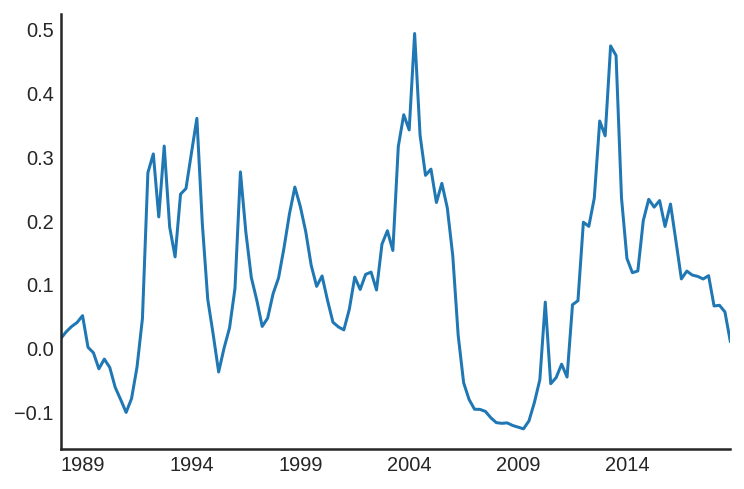

In [14]:
df["gZ"].plot()
sns.despine()
plt.show()

### Teste de Zivot-Andrews

In [118]:
print(ZivotAndrews(df["gZ"], trend = 'ct').summary(),"\n")
print(ZivotAndrews(df["gZ"].diff().dropna(), trend = 'c').summary(),"\n")

        Zivot-Andrews Results        
Test Statistic                 -4.056
P-value                         0.466
Lags                                7
-------------------------------------

Trend: Constant and Linear Time Trend
Critical Values: -5.58 (1%), -5.07 (5%), -4.83 (10%)
Null Hypothesis: The process contains a unit root with a single structural break.
Alternative Hypothesis: The process is trend and break stationary. 

        Zivot-Andrews Results        
Test Statistic                 -7.868
P-value                         0.000
Lags                                3
-------------------------------------

Trend: Constant
Critical Values: -5.28 (1%), -4.81 (5%), -4.57 (10%)
Null Hypothesis: The process contains a unit root with a single structural break.
Alternative Hypothesis: The process is trend and break stationary. 



**Conclusão:** Não rejeita-se, a 5% de significância, a hipótese nula do teste Zivot e Andrews (1992), ou seja, existe uma <u>quebra estrutural</u> na série analizada. Portanto, os testes de raíz unitária desta série estão comprometidos. Em outras palavras, na presença de quebra estrutural, os testes são viesados na direção da não rejeição da hipótese de raiz unitária. Em primeira diferença, a série é estacionária.


### Teste ADF

Será adotado o método BIC dada a maior parcimônia.

In [114]:
print(ADF(df["gZ"], trend='ct').summary())
print(ADF(df["gZ"].diff().dropna(), trend='c').summary())

   Augmented Dickey-Fuller Results   
Test Statistic                 -3.303
P-value                         0.066
Lags                                7
-------------------------------------

Trend: Constant and Linear Time Trend
Critical Values: -4.04 (1%), -3.45 (5%), -3.15 (10%)
Null Hypothesis: The process contains a unit root.
Alternative Hypothesis: The process is weakly stationary.
   Augmented Dickey-Fuller Results   
Test Statistic                 -7.629
P-value                         0.000
Lags                                3
-------------------------------------

Trend: Constant
Critical Values: -3.49 (1%), -2.89 (5%), -2.58 (10%)
Null Hypothesis: The process contains a unit root.
Alternative Hypothesis: The process is weakly stationary.


**Conclusão:** Série é fracamente estacionária em primeira diferença.

### Teste DFGLS

In [115]:
print(DFGLS(df["gZ"], trend='ct').summary())
print(DFGLS(df["gZ"].diff().dropna(), trend='c').summary())

      Dickey-Fuller GLS Results      
Test Statistic                 -3.155
P-value                         0.022
Lags                                7
-------------------------------------

Trend: Constant and Linear Time Trend
Critical Values: -3.59 (1%), -3.01 (5%), -2.72 (10%)
Null Hypothesis: The process contains a unit root.
Alternative Hypothesis: The process is weakly stationary.
      Dickey-Fuller GLS Results      
Test Statistic                 -7.546
P-value                         0.000
Lags                                3
-------------------------------------

Trend: Constant
Critical Values: -2.73 (1%), -2.11 (5%), -1.80 (10%)
Null Hypothesis: The process contains a unit root.
Alternative Hypothesis: The process is weakly stationary.


**Conclusão:** Série em nível e em primeira diferença são fracamente estacionárias.

### Teste KPSS

In [116]:
print(KPSS(df["gZ"], trend = 'ct').summary())
print(KPSS(df["gZ"].diff().dropna(), trend = 'c').summary())

    KPSS Stationarity Test Results   
Test Statistic                  0.072
P-value                         0.326
Lags                                6
-------------------------------------

Trend: Constant and Linear Time Trend
Critical Values: 0.22 (1%), 0.15 (5%), 0.12 (10%)
Null Hypothesis: The process is weakly stationary.
Alternative Hypothesis: The process contains a unit root.
    KPSS Stationarity Test Results   
Test Statistic                  0.045
P-value                         0.904
Lags                                2
-------------------------------------

Trend: Constant
Critical Values: 0.74 (1%), 0.46 (5%), 0.35 (10%)
Null Hypothesis: The process is weakly stationary.
Alternative Hypothesis: The process contains a unit root.


**Conclusão:** Série em nível e em primeira diferença são fracamente estacionária.

### Teste de Phillips-Perron

In [117]:
print(PhillipsPerron(df["gZ"], trend='ct').summary())
print(PhillipsPerron(df["gZ"].diff().dropna(), trend='c').summary())

     Phillips-Perron Test (Z-tau)    
Test Statistic                 -2.830
P-value                         0.186
Lags                               13
-------------------------------------

Trend: Constant and Linear Time Trend
Critical Values: -4.03 (1%), -3.45 (5%), -3.15 (10%)
Null Hypothesis: The process contains a unit root.
Alternative Hypothesis: The process is weakly stationary.
     Phillips-Perron Test (Z-tau)    
Test Statistic                 -9.753
P-value                         0.000
Lags                               13
-------------------------------------

Trend: Constant
Critical Values: -3.49 (1%), -2.89 (5%), -2.58 (10%)
Null Hypothesis: The process contains a unit root.
Alternative Hypothesis: The process is weakly stationary.


**Conclusão:** A um nível de significância de 5%, não rejeita-se a hipótese nula do teste Phillips-Perron e, portanto, suspeita-se que o processo contenha uma raíz unitária. Em primeira difenrença, a série é fracamente estacionária.

#### Investimento residencial: Conclusão

Há suspeitas de quebra estrutural na taxa de crescimento do investimento residencial e, portanto, os testes de raíz unitária podem ser comprometidos e são viesados na direção de não-rejeitação da hipótese de raíz unitária.

## Inflação do preço dos imóveis

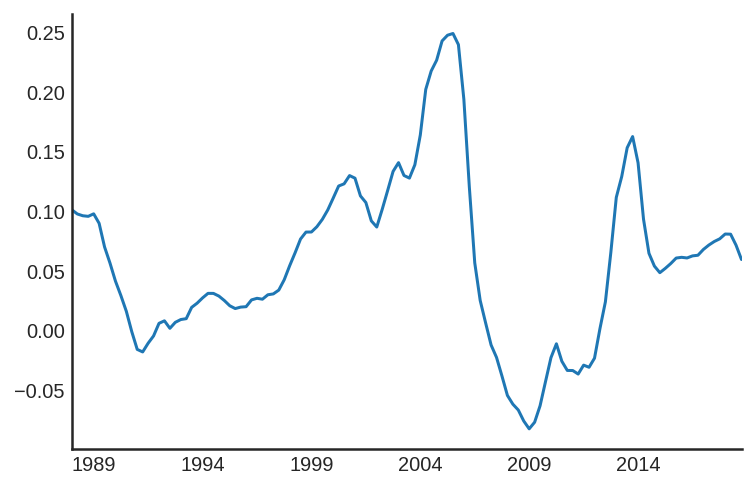

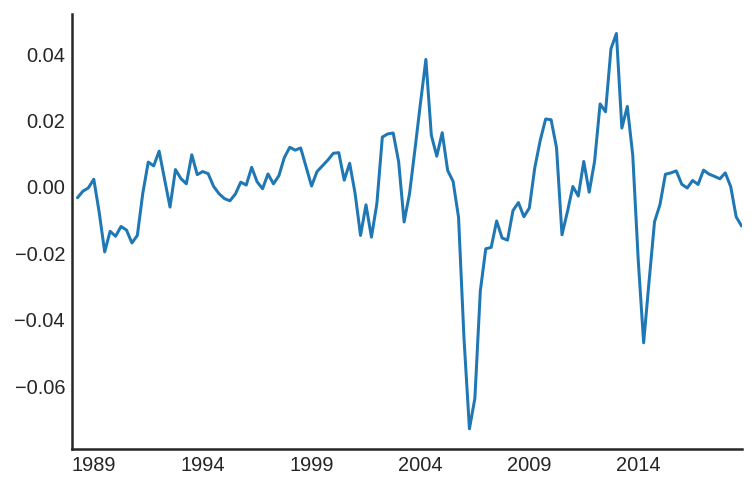

In [22]:
df["Inflação"].plot()
sns.despine()
plt.show()

df["Inflação"].diff().plot()
sns.despine()
plt.show()

Destaque será dado para os testes com intercepto e sem tendência.

### Teste de Chow


- H0: Sem quebra estrutural
- H1: Quebra estrutural


	 Optimal 2-segment partition: 

Call:
breakpoints.Fstats(obj = df.chow)

Breakpoints at observation number:
75 

Corresponding to breakdates:
2006(2) 
[1] "P-Valor do teste:"

	supF test

data:  df.chow
sup.F = 19.237, p-value = 0.0003311



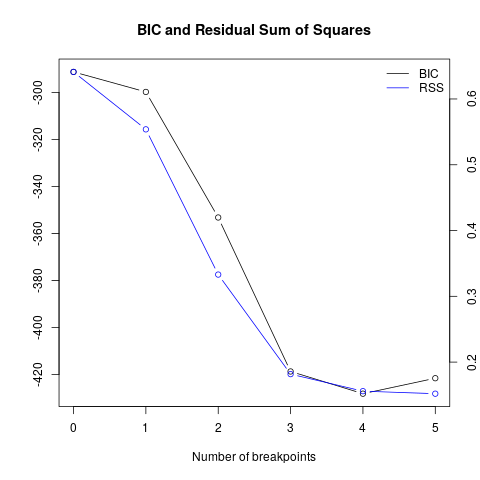

In [23]:
%%R -i df
df = df[,2]
df = ts(df, start = c(1987,4), frequency = 4)
df.chow = Fstats(df ~ 1, from = 0.15) 
print(breakpoints(df.chow)) #mostra o ponto da quebra quebra estrutural
print("P-Valor do teste:")
print(sctest(df.chow))
df.bp = breakpoints(df ~ 1, h = 0.15) #nota-se que a função "breakpoints" aponta, no máximo, cinco quebras estruturais, se houver
plot(summary(df.bp))

**Conclusão:** Rejeita-se, a 5% de significância, a hipótese nula do teste de Chow e, portanto, a série apresenta uma quebra estrutural.

### Teste de Phillips-Perron

In [24]:
print(PhillipsPerron(df["Inflação"], trend='ct').summary())
print(PhillipsPerron(df["Inflação"].diff().dropna(), trend='c').summary())

     Phillips-Perron Test (Z-tau)    
Test Statistic                 -2.272
P-value                         0.449
Lags                               13
-------------------------------------

Trend: Constant and Linear Time Trend
Critical Values: -4.03 (1%), -3.45 (5%), -3.15 (10%)
Null Hypothesis: The process contains a unit root.
Alternative Hypothesis: The process is weakly stationary.
     Phillips-Perron Test (Z-tau)    
Test Statistic                 -3.197
P-value                         0.020
Lags                               13
-------------------------------------

Trend: Constant
Critical Values: -3.49 (1%), -2.89 (5%), -2.58 (10%)
Null Hypothesis: The process contains a unit root.
Alternative Hypothesis: The process is weakly stationary.


**Conclusão:** A um nível de significância de 5%, não rejeita-se a hipótese nula do teste Phillips-Perron e, portanto, suspeita-se que o processo contenha uma raíz unitária. Em primeira diferença, a série é fracamente estacionária.

### Teste de Zivot-Andrews

In [25]:
print(ZivotAndrews(df["Inflação"], trend = 'ct').summary(),"\n")
print(ZivotAndrews(df["Inflação"].diff().dropna(), trend = 'c').summary(),"\n")

        Zivot-Andrews Results        
Test Statistic                 -5.371
P-value                         0.021
Lags                                6
-------------------------------------

Trend: Constant and Linear Time Trend
Critical Values: -5.58 (1%), -5.07 (5%), -4.83 (10%)
Null Hypothesis: The process contains a unit root with a single structural break.
Alternative Hypothesis: The process is trend and break stationary. 

        Zivot-Andrews Results        
Test Statistic                 -4.945
P-value                         0.035
Lags                                5
-------------------------------------

Trend: Constant
Critical Values: -5.28 (1%), -4.81 (5%), -4.57 (10%)
Null Hypothesis: The process contains a unit root with a single structural break.
Alternative Hypothesis: The process is trend and break stationary. 



**Conclusão:** Rejeita-se, a 5% de significância, a hipótese nula do teste Zivot e Andrews (1992), ou seja, **não** existe uma <u>quebra estrutural</u> na série analizada. O mesmo vale para a série em primeira diferença.

#### Inflação dos imóveis: Conclusão

Suspeita-se de quebra estrutural na série.

## Taxa de juros das hipotecas

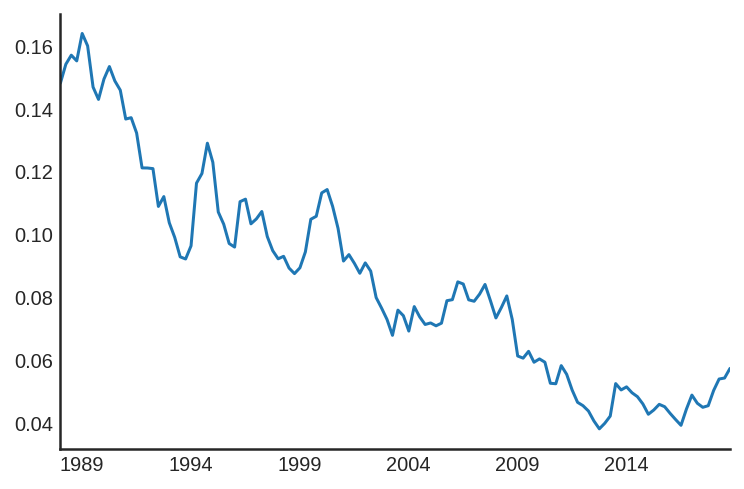

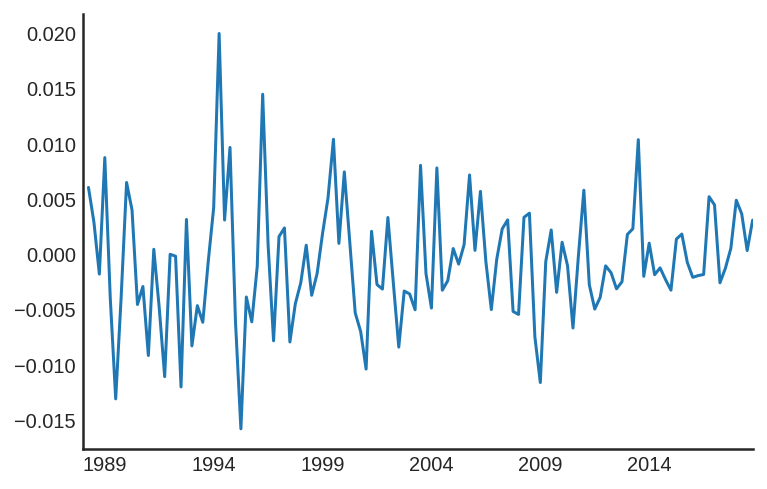

In [26]:
df["Taxa de juros"].plot()
sns.despine()
plt.show()

df["Taxa de juros"].diff().plot()
sns.despine()
plt.show()

Destaque será dado para o teste com constante e tendência.

### Teste de Phillips-Perron

In [27]:
print(PhillipsPerron(df["Taxa de juros"], trend='ct').summary())

     Phillips-Perron Test (Z-tau)    
Test Statistic                 -2.209
P-value                         0.485
Lags                               13
-------------------------------------

Trend: Constant and Linear Time Trend
Critical Values: -4.03 (1%), -3.45 (5%), -3.15 (10%)
Null Hypothesis: The process contains a unit root.
Alternative Hypothesis: The process is weakly stationary.


**Conclusão:** A um nível de significância de 5%, não rejeita-se a hipótese nula do teste Phillips-Perron e, portanto, suspeita-se que o processo contenha uma raíz unitária.

### Teste de Zivot-Andrews

In [28]:
print(ZivotAndrews(df["Taxa de juros"], trend = 'c').summary(),"\n") 
print(ZivotAndrews(df["Taxa de juros"], trend = 't').summary(),"\n")
print(ZivotAndrews(df["Taxa de juros"], trend = 'ct').summary(),"\n") ### Destaque

        Zivot-Andrews Results        
Test Statistic                 -3.732
P-value                         0.525
Lags                                8
-------------------------------------

Trend: Constant
Critical Values: -5.28 (1%), -4.81 (5%), -4.57 (10%)
Null Hypothesis: The process contains a unit root with a single structural break.
Alternative Hypothesis: The process is trend and break stationary. 

        Zivot-Andrews Results        
Test Statistic                 -3.954
P-value                         0.149
Lags                                8
-------------------------------------

Trend: Linear Time Trend (No Constant)
Critical Values: -5.03 (1%), -4.41 (5%), -4.14 (10%)
Null Hypothesis: The process contains a unit root with a single structural break.
Alternative Hypothesis: The process is trend and break stationary. 

        Zivot-Andrews Results        
Test Statistic                 -4.141
P-value                         0.411
Lags                                8
---

**Conclusão:** Não rejeita-se, a 5% de significância, a hipótese nula do teste Zivot e Andrews (1992), ou seja, **existe** uma <u>quebra estrutural</u> na série analizada.

### Teste de Chow


- H0: Sem quebra estrutural
- H1: Quebra estrutural


	 Optimal 2-segment partition: 

Call:
breakpoints.Fstats(obj = df.chow)

Breakpoints at observation number:
96 

Corresponding to breakdates:
2011(3) 
[1] "P-Valor do teste:"

	supF test

data:  df.chow
sup.F = 12.138, p-value = 0.009905



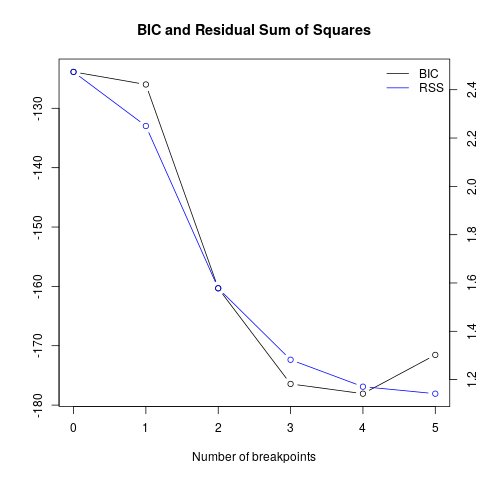

In [29]:
%%R -i df
df = df[,3]
df = ts(df, start = c(1987,4), frequency = 4)
df.chow = Fstats(df ~ 1, from = 0.15) 
print(breakpoints(df.chow)) #mostra o ponto da quebra quebra estrutural
print("P-Valor do teste:")
print(sctest(df.chow))
df.bp = breakpoints(df ~ 1, h = 0.15) #nota-se que a função "breakpoints" aponta, no máximo, cinco quebras estruturais, se houver
plot(summary(df.bp))

**Conclusão:** Rejeita-se, a 5% de significância, a hipótese nula do teste de Chow e, portanto, a série apresenta uma quebra estrutural.

#### Taxa de juros hipotecárias: Conclusão

Suspeita-se de quebra estrutural na série.

### Zivot-Andrews

In [30]:
ZivotAndrews(df['gZ'])

Test Statistic,-4.024
P-value,0.337
Lags,7


In [31]:
ZivotAndrews(df['gZ'].diff().dropna())

Test Statistic,-7.868
P-value,0.000
Lags,3


**Conclusão:** Processo possui uma quebra estrutural e uma raíz unitária em nível. Em primeira diferença, a série é estacionária em torno da tendência.

### Teste DFGLS

In [32]:
DFGLS(df['gZ'], method = "BIC").summary()

Test Statistic,-2.084
P-value,0.037
Lags,4


In [33]:
DFGLS(df['gZ'].diff().dropna(), method = "BIC").summary()

Test Statistic,-7.546
P-value,0.000
Lags,3


**Conclusão:** Já pelo teste de DFGLS conclui-se que a série é fracamente estacionária tanto em nível quanto em primeira diferença adotando um nível de significância de 5%.

### Teste KPSS

In [34]:
KPSS(df['gZ']).summary()

Test Statistic,0.081
P-value,0.689
Lags,6


In [35]:
KPSS(df['gZ'].diff().dropna()).summary()

Test Statistic,0.045
P-value,0.904
Lags,2


**Conclusão:** Pelo teste de KPSS conclui-se que a série é fracamente estacionária tanto em nível quanto em primeira diferença adotando um nível de significância de 5%.

### Teste de Phillip Perron

In [36]:
PhillipsPerron(df["gZ"]).summary()

Test Statistic,-2.876
P-value,0.048
Lags,13


In [37]:
PhillipsPerron(df["gZ"].diff().dropna()).summary()

Test Statistic,-9.753
P-value,0.000
Lags,13


**Conclusão:** Série é estacionária em primeira diferença.

#### Investimento residencial - Estacionariedade: Conclusão

Uma vez que a série possui uma quebra estrutural, os resultados do testes são viesados no sentido de apontar uma raíz unitária em uma série que é estacionária (ver [p. 14](http://www.iea.sp.gov.br/ftpiea/ie/2001/tec1-0401.pdf)). Desse modo, pelos testes KPSS e DFGLS indicarem que a série é fracamente estacionária enquanto o ADF, Phillip-Perron e Zivot-Andrews indicam o oposto (provavelmente pela quebra estrutural), adota-se a série tomada em primeira diferença.

    df["gZ"] = df["gZ"].diff()

## Inflação dos imóveis

### Autocorrelação e autoccorelação parcial

{{plot_acf(df["Inflação"]);sns.despine(); plt.show()}}
{{plot_pacf(df["Inflação"]);sns.despine(); plt.show()}}


### Inspeção gráfica 

{{df["Inflação"].plot();sns.despine(); plt.show()}}

A análise do gráfico da taxa de inflação indica que a série não possui tendência mas tem intercepto. Deste modo, o teste a ser considerado é aquele cujo valor crítico é $\tau^B$.

In [38]:
ADF(df['Inflação'], method = 'BIC').summary()

Test Statistic,-3.147
P-value,0.023
Lags,5


In [39]:
ADF(df['Inflação'].diff().dropna(), method = 'BIC').summary()

Test Statistic,-5.094
P-value,0.000
Lags,1


**Conclusão:** Adotando um nível de significância de 5%, conclui-se pelo teste ADF que a série é fracamente estacionária. Tal resultado permanece diante da possibilidade de quebra estrutural uma vez que os resultados são viasados no sentido da não rejeição da hipótese nula do teste.

### Teste Zivot-Andrews

In [40]:
ZivotAndrews(df["Inflação"], trend = 'c').summary()

Test Statistic,-5.501
P-value,0.004
Lags,6


In [41]:
ZivotAndrews(df["Inflação"].diff().dropna(), trend = 'c').summary()

Test Statistic,-4.945
P-value,0.035
Lags,5


**Conclusão:** Processo é fracamente estacionário em nível.

### Teste DFGLS

In [42]:
DFGLS(df['Inflação'], method = 'BIC').summary()

Test Statistic,-2.791
P-value,0.005
Lags,5


In [43]:
DFGLS(df['Inflação'].diff().dropna(), method = 'BIC').summary()

Test Statistic,-5.042
P-value,0.000
Lags,1


**Conclusão:** Obtém-se as mesmas conclusões do teste anterior, qual seja, a série é fracamente estacionária.

### Teste KPSS

In [44]:
KPSS(df['Inflação']).summary()

Test Statistic,0.119
P-value,0.501
Lags,6


In [45]:
KPSS(df['Inflação'].diff().dropna()).summary()

Test Statistic,0.055
P-value,0.845
Lags,5


**Conclusão:** Obtém-se as mesmas conclusões do teste ADF e DFGLS, qual seja, a série é fracamente estacionária.

### Teste Phillip-Perron

In [46]:
PhillipsPerron(df["Inflação"]).summary()

Test Statistic,-2.271
P-value,0.182
Lags,13


In [47]:
PhillipsPerron(df["Inflação"].diff().dropna()).summary()

Test Statistic,-3.197
P-value,0.020
Lags,13


**Conclusão:** Série fracamente estacionária em primeira diferença.

#### Inflação de imóveis - Estacionariedade: Conclusão

Pelos testes realizados anteriormente (exceto Phillips-Perron), conclui-se que há indícios que a série seja fracamente estacionária em nível a um nível de significância de 5%. Os mesmos resultados foram obtidos via gretl e podem ser viasualizados nos resultados do script.

    df["Inflação"] = df["Inflação"]

## Taxa de juros das hipotecas

{{df["Taxa de juros"].plot();sns.despine();plt.show()}}

Pela análise gráfica, verifica-se que a série possui intercepto e tendência e isso será incluido nos testes. Além disso, dada a presença de quebra estrutural, será considerando $\tau^c = -4,24$.

### Teste ADF

In [48]:
ADF(df['Taxa de juros'], method='BIC', trend='ct').summary()

Test Statistic,-3.171
P-value,0.090
Lags,1


In [49]:
ADF(df['Taxa de juros'].diff().dropna(), method='BIC', trend='ct').summary()

Test Statistic,-9.167
P-value,0.000
Lags,0


**Conclusão:** Considerando os valores críticos para o teste com presença de raíz unitária fornecidos por Bueno (2005), conclui-se a 5% de significância que a série em nível possui uma raíz unitária enquanto a série em primeira diferença é estacionária.

### Teste Zivot Andrews

In [50]:
ZivotAndrews(df["Taxa de juros"], trend='ct').summary()

Test Statistic,-4.141
P-value,0.411
Lags,8


In [51]:
ZivotAndrews(df["Taxa de juros"].diff().dropna(), trend='c').summary()

Test Statistic,-7.457
P-value,0.000
Lags,3


**Conclusão:** Série é fracamente estacionária em primeira diferença.

### Teste DFGLS

In [52]:
DFGLS(df['Taxa de juros'], method='BIC', trend='ct').summary()

Test Statistic,-2.980
P-value,0.036
Lags,1


In [53]:
DFGLS(df['Taxa de juros'].diff().dropna(), method='BIC', trend='ct').summary()

Test Statistic,-7.681
P-value,0.000
Lags,0


**Conclusão:** Adotando um nível de significância de 5%, conclui-se que a série é fracamente estacionária pelo teste DFGLS e o mesmo vale para a primeira diferença.

### Teste KPSS

In [54]:
KPSS(df['Taxa de juros'], trend='ct').summary()

Test Statistic,0.139
P-value,0.061
Lags,6


In [55]:
KPSS(df['Taxa de juros'].diff().dropna(), trend='ct').summary()

Test Statistic,0.036
P-value,0.786
Lags,0


**Conclusão:** Obtém-se os mesmos resultados do teste anterior adotando um nível de significância de 5%, ou seja, a série é fracamente estacionária.

#### Teste Phillips-Perron

In [56]:
PhillipsPerron(df["Taxa de juros"]).summary()

Test Statistic,-1.701
P-value,0.430
Lags,13


In [57]:
PhillipsPerron(df["Taxa de juros"].diff().dropna()).summary()

Test Statistic,-8.999
P-value,0.000
Lags,13


**Conclusão:** Série é fracamente estacionária em primeira diferença.

#### Taxa de juros das hipotecas - Estacionariedade: Conclusão

Dada a presença de quebra estrutural, os testes de raíz unitária tendem a apontar que uma série estacionária é não estacionária, ou seja, os resultados dos testes são viesados. Desse modo, pelos testes KPSS e DFGLS, conclui-se que a série é fracamente estacionária enquanto o teste ADF afirma o oposto. No entanto, pela inspeção gráfica da série e das funções de autocorrelação e autocorreção parcial (abaixo), conclui-se a série deve ser tomada em primeira diferença. Os testes de Phillips-Perron e Zivot-Andrews corroboram para tal decisão.

    df["Taxa de juros"] = df["Taxa de juros"].diff()


### Autocorrelação e autoccorelação parcial - série em nível

{{plot_acf(df["Taxa de juros"]);sns.despine(); plt.show()}}
{{plot_pacf(df["Taxa de juros"]);sns.despine(); plt.show()}}


### Autocorrelação e autoccorelação parcial - série em diferença

{{plot_acf(df["Taxa de juros"].diff().dropna());sns.despine(); plt.show()}}
{{plot_pacf(df["Taxa de juros"].diff().dropna());sns.despine(); plt.show()}}


## Investimento residencial  - Inflação de imóveis

Resta testar se existe alguma relação de longo prazo entre inflação de imóveis e investimento residencial.

Testando: 

$$
y = g_Z - \text{Infla} 
$$


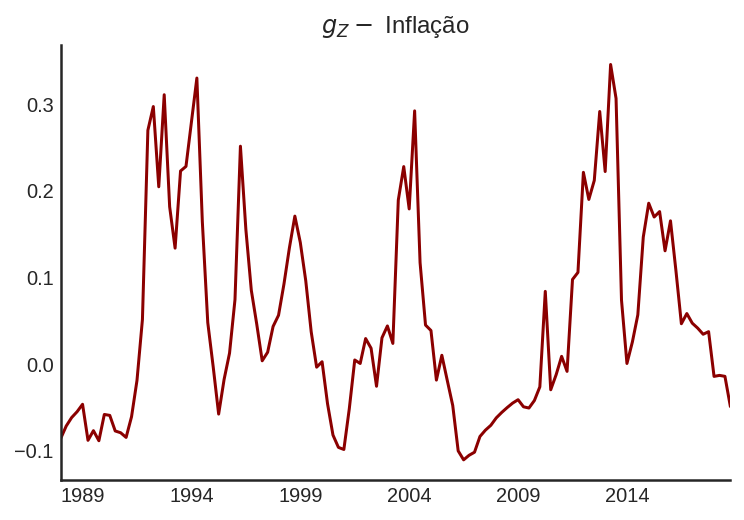

In [58]:
(df["gZ"] - df["Inflação"]).plot(color = 'darkred', title ='$g_Z - $ Inflação')
sns.despine()
plt.show()

### Teste ADF

In [59]:
ADF((df['gZ']-df["Inflação"]), method = 'BIC').summary()

Test Statistic,-2.681
P-value,0.077
Lags,4


In [60]:
DFGLS((df['gZ']-df["Inflação"]), method = 'BIC').summary()

Test Statistic,-1.779
P-value,0.074
Lags,4


In [61]:
KPSS((df['gZ']-df["Inflação"])).summary()

Test Statistic,0.093
P-value,0.620
Lags,6


In [62]:
ZivotAndrews((df['gZ']-df["Inflação"])).summary()

Test Statistic,-3.249
P-value,0.819
Lags,4


In [63]:
PhillipsPerron((df['gZ']-df["Inflação"]))

Test Statistic,-3.123
P-value,0.025
Lags,13


#### Investimento - Inflação: Conclusão

A diferença entre as séries não é estacionária.

# Seleção das variávies

In [64]:
df["Taxa de juros"] = df["Taxa de juros"].diff()
df["gZ"] = df["gZ"].diff()
#df["Inflação"] = df["Inflação"].diff()
df = df[["Taxa de juros", "Crise", "Inflação", "gZ"]].dropna() # Ordenação de Cholesky
df.head()

,Taxa de juros,Crise,Inflação,gZ
,,,,
1988-06-30,0.006016,0,0.097437,0.010722
1988-09-30,0.002879,0,0.095949,0.008294
1988-12-31,-0.001817,0,0.095454,0.006252
1989-03-31,0.008713,0,0.097561,0.010689
1989-06-30,-0.003937,0,0.089601,-0.049557


# VAR

**Dúvida:** Variável exógena do VAR deve ser estacionária também?

In [65]:
model = VAR(
    df[["Inflação", "gZ"]], 
    exog = df[["Taxa de juros", "Crise"]]
)
print(model.select_order(maxlags=12).summary())

 VAR Order Selection (* highlights the minimums)  
       AIC         BIC         FPE         HQIC   
--------------------------------------------------
0       -10.87      -10.72   1.900e-05      -10.81
1       -13.85      -13.61   9.664e-07      -13.75
2       -14.70      -14.36   4.124e-07      -14.56
3       -14.77      -14.33   3.839e-07      -14.60
4       -15.00     -14.47*   3.055e-07      -14.78
5      -15.06*      -14.43  2.873e-07*     -14.81*
6       -15.04      -14.31   2.942e-07      -14.75
7       -15.01      -14.18   3.051e-07      -14.67
8       -14.96      -14.03   3.213e-07      -14.58
9       -14.90      -13.88   3.401e-07      -14.49
10      -14.88      -13.76   3.496e-07      -14.42
11      -14.83      -13.61   3.671e-07      -14.34
12      -14.77      -13.46   3.910e-07      -14.24
--------------------------------------------------


Adotando o BIC como critério de seleção dada a parciomônia, estima-se uma VAR de ordem 5.

## Estimação

In [66]:
results = model.fit(ic='bic')
print(results.summary())

  Summary of Regression Results   
Model:                         VAR
Method:                        OLS
Date:           qua, 20, nov, 2019
Time:                     15:47:36
--------------------------------------------------------------------
No. of Equations:         2.00000    BIC:                   -14.5805
Nobs:                     119.000    HQIC:                  -14.8857
Log likelihood:           582.404    FPE:                2.78666e-07
AIC:                     -15.0943    Det(Omega_mle):     2.33502e-07
--------------------------------------------------------------------
Results for equation Inflação
                 coefficient       std. error           t-stat            prob
------------------------------------------------------------------------------
const               0.003964         0.001363            2.908           0.004
exog0               0.203873         0.160205            1.273           0.203
exog1              -0.005955         0.002583           -2.305   

## Inspeção

### Gráfico dos inputs

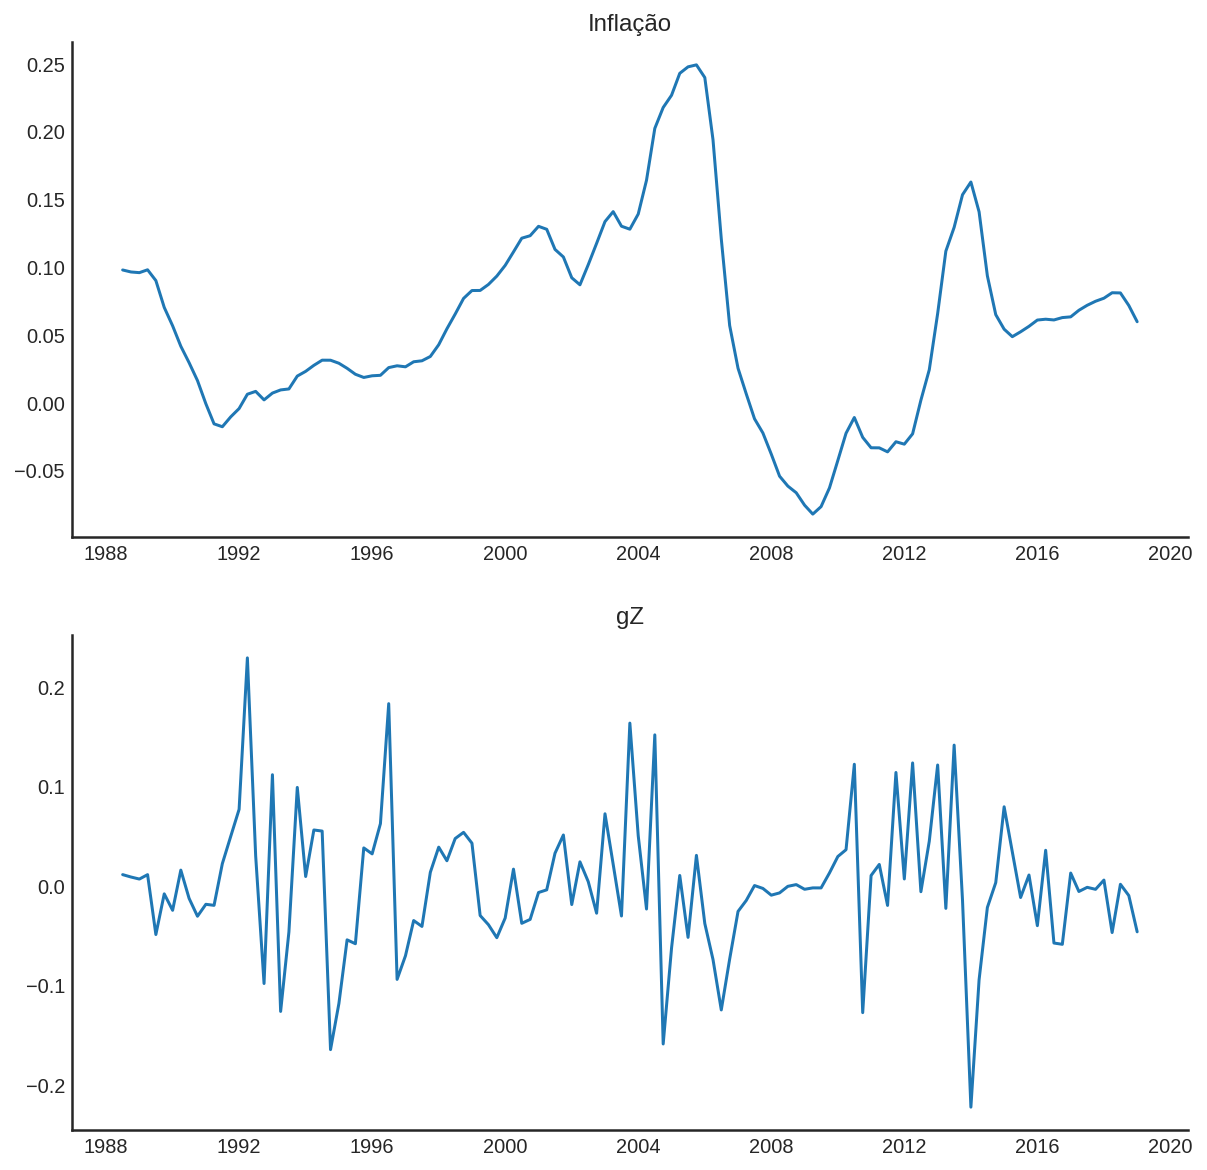

In [67]:
results.plot()
sns.despine()
plt.show()

### Autocorrelação dos resíduos 

**OBS:** série consigo mesma na diagonal principal.

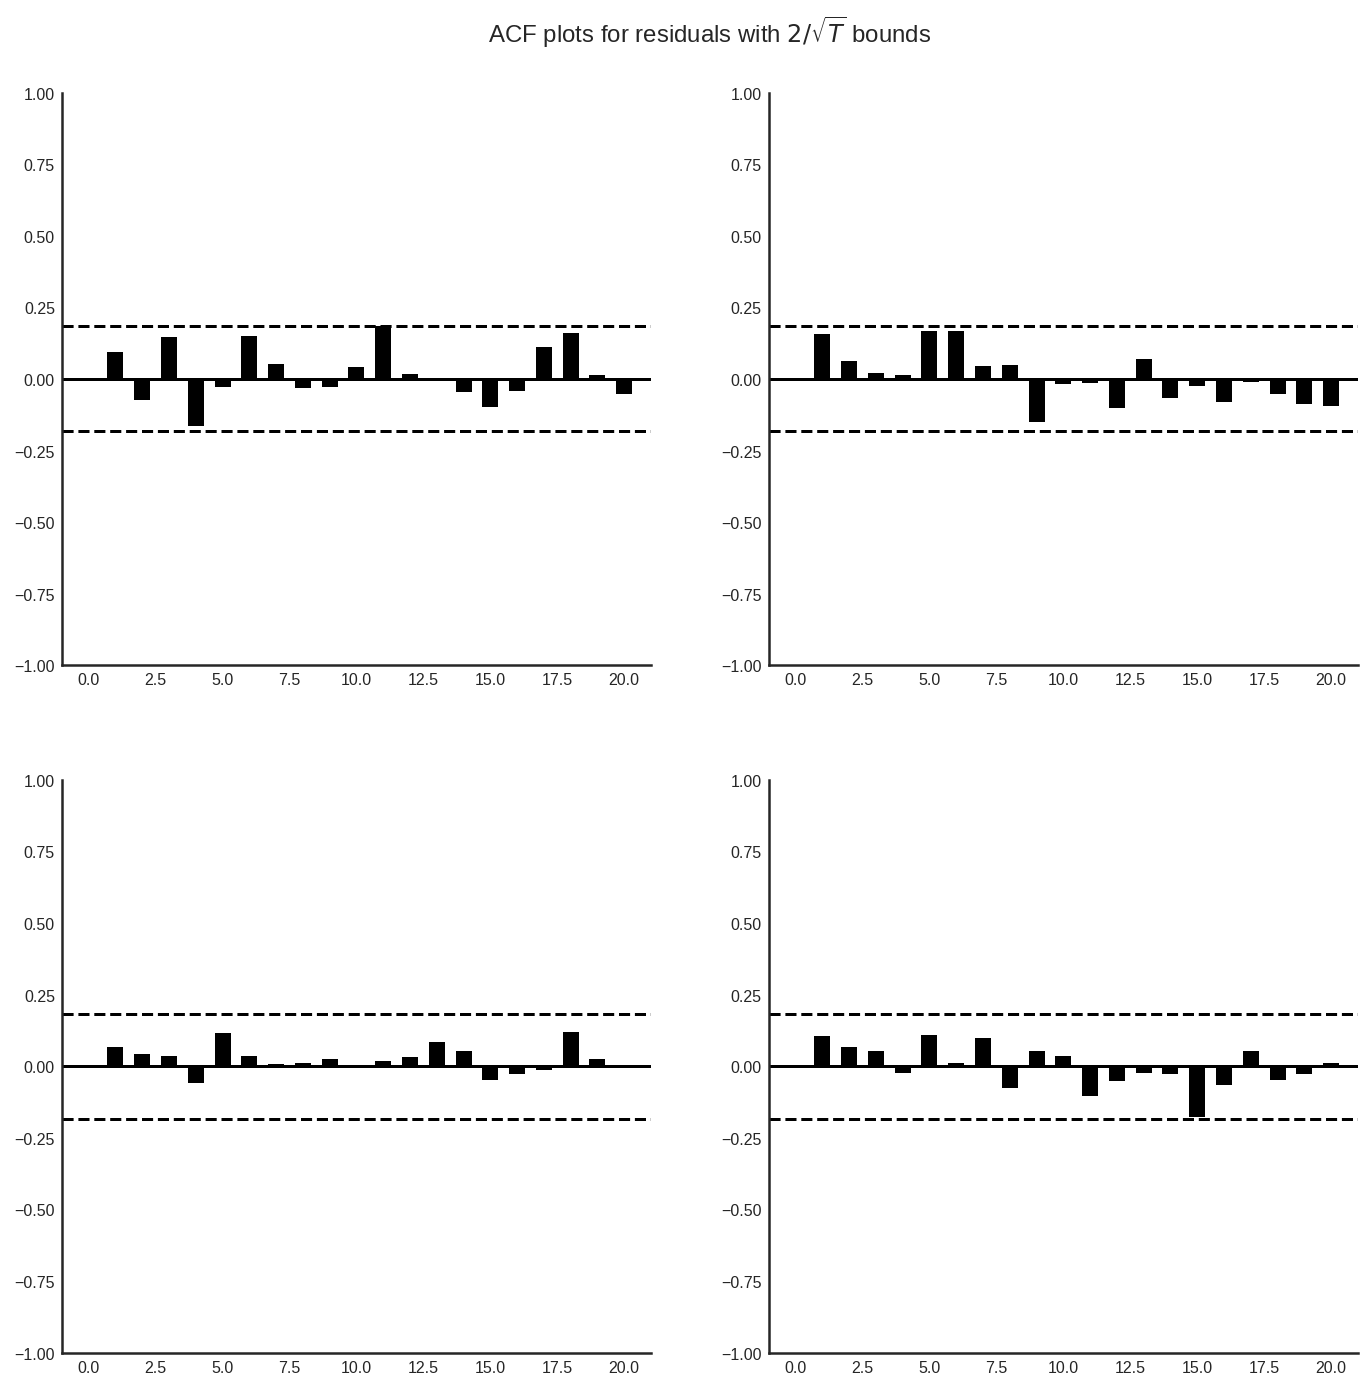

In [68]:
results.plot_acorr(nlags = 20)
sns.despine()
plt.show()

**Conclusão:** Pela inspeção gráfica, o modelo não apresenta autocorrelação seria dos resíduos.

### Estabilidade

In [69]:
print("Estável:", results.is_stable(verbose=True))

Eigenvalues of VAR(1) rep
0.8358933660193383
0.8358933660193383
0.4805177123909676
0.4805177123909676
0.7961783387946113
0.7961783387946113
0.8056412828348928
0.8056412828348928
Estável: True


**OBS:** Apesar de estar escrito VAR(1), os resultados acima correspondem ao VAR(p)

### Teste de Autocorrelação dos Resı́duos

**Teste de Portmanteau:** Verificar se as autocorrelações multivariadas são nulas

- usada para testar que as autocorrelações e
correlações cruzadas não são significativas, para um dado nı́vel
de significância

- H0: Não correlação serial até o lag n
- H1: Há correlação serial até o lag n

In [70]:
results.test_whiteness(nlags=12).summary()

Test statistic,Critical value,p-value,df
41.23,46.19,0.127,32


**Conclusão:** Os resíduos **não** apresentam correlação serial.

In [71]:
results.test_whiteness(nlags=12, adjusted=True).summary()

Test statistic,Critical value,p-value,df
43.57,46.19,0.083,32


**OBS:** Com adjusted = True é feito o teste de Breusch-Godfrey

**Conclusão:** Os resíduos **não** apresentam correlação serial.

#### Teste de Ljung-Box

In [72]:
def LjungBox_Pierce(resid, signif = 0.05, boxpierce = False, k = 4):
  """
  resid = residuals df
  signif = signif. level
  """
  var = len(resid.columns)
  print("H0: autocorrelations up to lag k equal zero")
  print('H1: autocorrelations up to lag k not zero')
  print("Box-Pierce: ", boxpierce)
  
  for i in range(var):
    print("Testing for ", resid.columns[i].upper(), ". Considering a significance level of",  signif*100,"%")
    result = acorr_ljungbox(x = resid.iloc[:,i-1], lags = k, boxpierce = boxpierce)[i-1] < signif
    for j in range(k):
      print("Reject H0 on lag " ,j+1,"? ", result[j])
    print("\n")
    

In [73]:
LjungBox_Pierce(results.resid, k = 12, boxpierce=False)

H0: autocorrelations up to lag k equal zero
H1: autocorrelations up to lag k not zero
Box-Pierce:  False
Testing for  INFLAÇÃO . Considering a significance level of 5.0 %
Reject H0 on lag  1 ?  False
Reject H0 on lag  2 ?  False
Reject H0 on lag  3 ?  False
Reject H0 on lag  4 ?  False
Reject H0 on lag  5 ?  False
Reject H0 on lag  6 ?  False
Reject H0 on lag  7 ?  False
Reject H0 on lag  8 ?  False
Reject H0 on lag  9 ?  False
Reject H0 on lag  10 ?  False
Reject H0 on lag  11 ?  False
Reject H0 on lag  12 ?  False


Testing for  GZ . Considering a significance level of 5.0 %
Reject H0 on lag  1 ?  False
Reject H0 on lag  2 ?  False
Reject H0 on lag  3 ?  False
Reject H0 on lag  4 ?  False
Reject H0 on lag  5 ?  False
Reject H0 on lag  6 ?  False
Reject H0 on lag  7 ?  False
Reject H0 on lag  8 ?  False
Reject H0 on lag  9 ?  False
Reject H0 on lag  10 ?  False
Reject H0 on lag  11 ?  False
Reject H0 on lag  12 ?  False




### Normalidade

In [74]:
results.test_normality().summary()

Test statistic,Critical value,p-value,df
16.60,9.488,0.002,4


## Inspeção dos resíduos

In [75]:
residuals = pd.DataFrame(results.resid)
residuals.columns = ["Inflação", 'gZ']
residuals.tail()

,Inflação,gZ
,,
2017-12-31,0.000225,0.007173
2018-03-31,0.001325,-0.062426
2018-06-30,-0.004309,-0.003512
2018-09-30,-0.007815,-0.020811
2018-12-31,-0.002562,-0.042838


### ARCH-LM

In [76]:
def ARCH_LM(resid, signif = 0.05, autolag = 'bic'):
  """
  df = residuals df
  signif = signif. level
  """
  var = len(resid.columns)
  print("H0: Residuals are homoscedastic")
  print('H1: Residuals are heteroskedastic')
  
  for i in range(var):
    print("Testing for ", resid.columns[i].upper())
    result = het_arch(resid = resid.iloc[:,i], autolag = autolag)
    print('LM p-value: ', result[1])
    print("Reject H0? ", result[1] < signif)
    print('F p-value: ', result[3])
    print("Reject H0? ", result[3] < signif)
    print('\n')
    

In [77]:
ARCH_LM(residuals)

H0: Residuals are homoscedastic
H1: Residuals are heteroskedastic
Testing for  INFLAÇÃO
LM p-value:  0.0014357797890077253
Reject H0?  True
F p-value:  0.0012609712969068455
Reject H0?  True


Testing for  GZ
LM p-value:  0.051744826683253135
Reject H0?  False
F p-value:  0.05234845104088973
Reject H0?  False




**Conclusão:** Os resíduos apresentam heterocedasticidade condicional, impossibilitando a inferência estatística. Uma forma de contornar tal problema é por meio de estimadores robustos, o que não está implementado no python e será feito no gretl.

### Conjunto

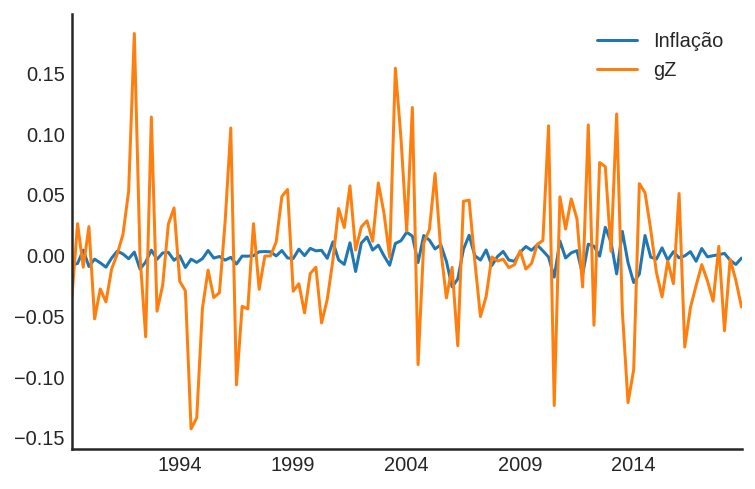

In [78]:
residuals.plot()
sns.despine()
plt.show()

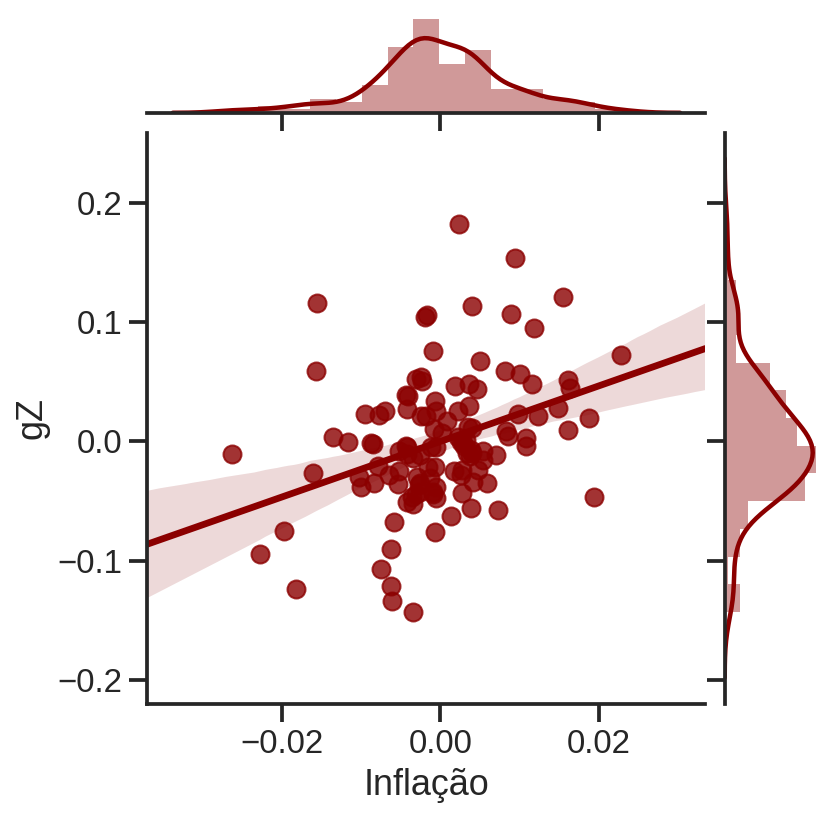

In [79]:
sns.set_context('talk')
ax = sns.jointplot(
    x = 'Inflação', 
    y = 'gZ', 
#    data = residuals**2, kind="kde", space = 0, color = 'black',
    data = residuals, color = 'darkred', kind="reg", 
)
plt.show()

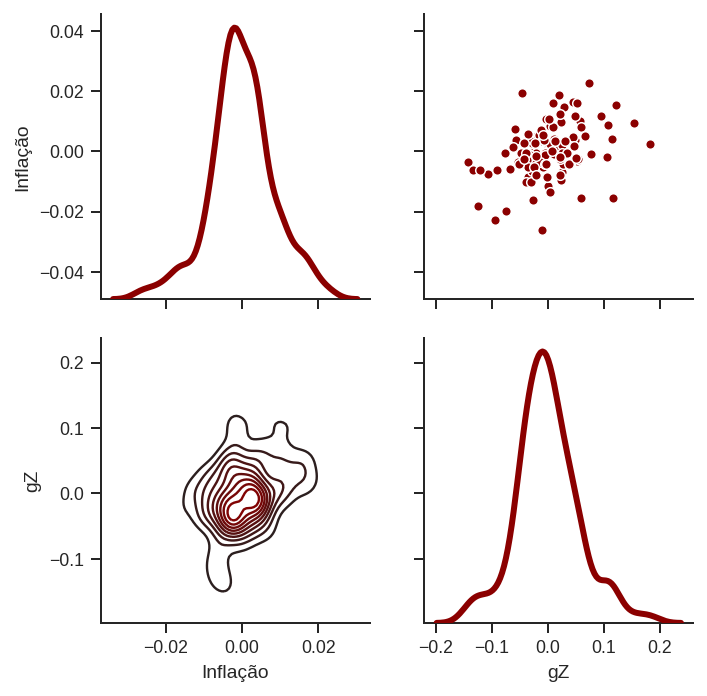

FileNotFoundError: [Errno 2] Arquivo ou diretório inexistente: './Escrita/Figs/Residuos_4.png'

In [80]:
sns.set_context('paper')
g = sns.PairGrid(residuals, diag_sharey=False)
g.map_lower(sns.kdeplot, color = 'darkred')
g.map_upper(sns.scatterplot, color = 'darkred')
g.map_diag(sns.kdeplot, lw=3, color = 'darkred')
plt.show()
g.savefig("./Escrita/Figs/Residuos_4.png", dpi=300)

### Investimento residencial

In [ ]:
sns.distplot(residuals["gZ"])
sns.despine()
plt.show()

In [ ]:
sns.scatterplot(x = residuals['gZ'], y = residuals['gZ']**2)
sns.despine()
plt.show()

In [ ]:
sns.scatterplot(
    y = residuals['gZ'], 
    x = residuals['gZ'].shift(-1), 
    color = 'darkred' 
)
sns.despine()
plt.xlabel("$g_Z(-1)$")
plt.show()

### Inflação

In [ ]:
sns.distplot(residuals["Inflação"])
sns.despine()
plt.show()

In [ ]:
sns.scatterplot(x = residuals['Inflação'], y = residuals['Inflação']**2)
sns.despine()
plt.show()

In [ ]:
sns.scatterplot(y = residuals['Inflação'], x = residuals['Inflação'].shift(-1), color = 'darkred')
sns.despine()
plt.xlabel("Inflação (-1)")
plt.show()

## Função resposta ao impulso

In [ ]:
p = results.irf(12).plot(orth=False)
p.suptitle("")
sns.despine()
plt.show()
p.savefig("./Escrita/Figs/Impulso.png", dpi = 300)

In [ ]:
p = results.irf(20).plot(orth=True)
p.suptitle("")
sns.despine()
plt.show()
p.savefig("./Escrita/Figs/Impulso_Orth.png", dpi = 300)

## Efeito cumulativo

In [ ]:
p = results.irf(12).plot_cum_effects(orth=True)
sns.despine()
plt.show()
p.savefig("./Escrita/Figs/Impulso_Cum.png", dpi = 300)

## Teste Causalidade de Granger

In [ ]:
results.test_causality(caused = 'gZ', causing = 'Inflação', signif = 0.05).summary()

**Conclusão:** A um nível de significância de 5%, Inflação granger causa $g_Z$

## Decomposição da variância

In [ ]:
p = results.fevd(20).plot()
sns.despine()
plt.show()
p.savefig("./Escrita/Figs/DecompVar.png", dpi = 300)

# VECM

In [ ]:
df = web.DataReader(
    [
        "PRFI",
        "CSUSHPISA",
        "MORTGAGE30US",
        "CPIAUCSL"
    ], 
    'fred', 
    start, 
    end
)
df.columns = [
    "Investimento residencial", 
    "Preço dos imóveis", 
    "Taxa de juros",
    "Inflação",
]
df.index.name = ""
df['Taxa de juros'] = df['Taxa de juros'].divide(100)
df = df.resample('Q').mean()
df['Preço dos imóveis'] = df['Preço dos imóveis']*df['Preço dos imóveis']["1999-12-31"]/df['Preço dos imóveis'][0]/100
df['Inflação'] = (df['Inflação']*df['Inflação']["1999-12-31"]/df['Inflação'][0]/100).pct_change(4)
df["Inflação imóveis"] = df["Preço dos imóveis"].pct_change(4)
df['gZ'] = df["Investimento residencial"].pct_change(4)
df["Taxa de juros real"] = ((1+df["Taxa de juros"])/(1+df["Inflação"])) -1
df["Taxa Própria"] = ((1+df["Taxa de juros"])/(1+df["Inflação imóveis"])) -1

fig, ax = plt.subplots(figsize = (8,5))

df[["gZ", "Taxa de juros real", "Taxa Própria"]].rolling(4).mean().dropna().plot(lw=2.5, ax = ax)
ax.axhline(y=0, color = 'black', lw=1.5, ls='--', zorder=0)
sns.despine()
plt.show()
fig.savefig("./Escrita/Figs/TxPropria_Investo.png", dpi = 300, bbox_inches = 'tight',
    pad_inches = 0.2, transparent = True,)

In [ ]:
df = web.DataReader(
    [
        "PRFI",
        "CSUSHPISA",
        "MORTGAGE30US",
        "PCDG",
        "FLTOTALSL"
    ], 
    'fred', 
    start, 
    end
)
df.columns = [
    "Investimento residencial", 
    "Preço dos imóveis", 
    "Taxa de juros",
    "Duráveis",
    "Crédito"
]
df.index.name = ""
df['Taxa de juros'] = df['Taxa de juros'].divide(100)
df = df.resample('Q').mean()
df['Preço dos imóveis'] = df['Preço dos imóveis']*df['Preço dos imóveis']["1999-12-31"]/df['Preço dos imóveis'][0]/100
df["gDuráveis"], *_ = yeojohnson(df["Duráveis"].pct_change(4))
df["gCrédito"], *_ = yeojohnson(df["Crédito"].pct_change(4))
df["Inflação"], *_ = yeojohnson(df["Preço dos imóveis"].pct_change(4))
df['gZ'], *_ = yeojohnson(df["Investimento residencial"].pct_change(4))
df["Taxa de juros"], *_ = yeojohnson(df["Taxa de juros"])
df["Taxa Própria"] = ((1+df["Taxa de juros"])/(1+df["Inflação"])) -1

df["Crise"] = [0 for i in range(len(df["gZ"]))]
for i in range(len(df["Crise"])):
    if df.index[i] > datetime.datetime(2006,4,1) and df.index[i] < datetime.datetime(2011,7,1):
        df["Crise"][i] = 1

df.to_csv("Dados_yeojohnson.csv", )

df = df[["Taxa de juros", "Inflação", "gZ", "Crise", "Taxa Própria"]]
        
df = df.dropna()
df.plot()
sns.despine()
plt.show()

In [ ]:
fig, ax = plt.subplots(2,2, figsize = (16,5))

trimestres = 2

sns.regplot(y = df["gZ"], x = df["Taxa Própria"].shift(-trimestres), color = 'black', ax = ax[0,0], order = 2)
ax[0,0].set_xlabel('Taxa própria defasada em {} trimestres'.format(trimestres))

sns.regplot(x = df["gZ"].shift(-trimestres), y = df["Taxa Própria"], color = 'black', ax = ax[0,1], order = 2)
ax[0,1].set_xlabel('$g_Z$ defasada em {} trimestres'.format(trimestres))


trimestres = 5

sns.regplot(y = df["gZ"], x = df["Taxa Própria"].shift(-trimestres), color = 'black', ax = ax[1,0], order = 2)
ax[1,0].set_xlabel('Taxa própria defasada em {} trimestres'.format(trimestres))

sns.regplot(x = df["gZ"].shift(-trimestres), y = df["Taxa Própria"], color = 'black', ax = ax[1,1], order = 2)
ax[1,1].set_xlabel('$g_Z$ defasada em {} trimestres'.format(trimestres))

sns.despine()
fig.tight_layout()
plt.show()
fig.savefig("./Escrita/Figs/Scatter_VECM.png", dpi = 300, bbox_inches = 'tight',
    pad_inches = 0.2, transparent = True,)

In [ ]:
from statsmodels.tsa.vector_ar.vecm import select_order

with open('./Escrita/lag_order.tex','w') as fh:
    fh.write(select_order(df[["Taxa Própria", "gZ"]], maxlags=15).summary().as_latex_tabular(tile = "Selação ordem do VECM"))

select_order(df[["Taxa Própria", "gZ"]], maxlags=15).summary()

In [ ]:
model = VECM(
    endog = df[["Taxa Própria", "gZ"]],
    #k_ar_diff=1
    #k_ar_diff=4
    k_ar_diff=5
    #k_ar_diff=9
)
results = model.fit()

with open('./Escrita/ajuste.tex','w') as fh:
    fh.write(results.summary().as_latex())

results.summary()

In [ ]:
results.test_whiteness(nlags=15).summary()

In [ ]:
results.test_whiteness(nlags=15, adjusted=True).summary()

In [ ]:
results.test_normality().summary()

In [ ]:
residuals = pd.DataFrame(results.resid, columns = ["Taxa Própria", "gZ"])
LjungBox_Pierce(residuals, k = 12, boxpierce=False)

In [ ]:
LjungBox_Pierce(residuals, k = 12, boxpierce=True)

In [ ]:
ARCH_LM(residuals)

In [ ]:
p = results.irf(15).plot(orth=True)
p.suptitle("")
sns.despine()
plt.show()
p.savefig("./Escrita/Figs/Impulso_VECMOrth.png", dpi = 300, bbox_inches = 'tight',
    pad_inches = 0.2, transparent = True,)

In [ ]:
p = results.irf(20).plot(orth=False)
p.suptitle("")
sns.despine()
plt.show()
p.savefig("./Escrita/Figs/Impulso_VECM.png", dpi = 300, bbox_inches = 'tight',
    pad_inches = 0.2, transparent = True,)

In [ ]:
sns.scatterplot(y = residuals['Taxa Própria'], x = residuals['Taxa Própria'].shift(-1), color = 'darkred')
sns.despine()
plt.xlabel("Tx. Própria (-1)")
plt.show()

In [ ]:
sns.scatterplot(y = residuals['gZ'], x = residuals['gZ'].shift(-1), color = 'darkred')
sns.despine()
plt.xlabel("gZ (-1)")
plt.show()

In [ ]:
sns.set_context('paper')
g = sns.PairGrid(residuals, diag_sharey=False)
g.map_lower(sns.kdeplot, color = 'darkred')
g.map_upper(sns.scatterplot, color = 'darkred')
g.map_diag(sns.kdeplot, lw=3, color = 'darkred')
plt.show()
g.savefig("./Escrita/Figs/Residuos_4VECM.png", dpi = 300, bbox_inches = 'tight',
    pad_inches = 0.2, transparent = True,)

## FEVD

In [ ]:
%%R -o fevd_gz
library(tsDyn)
library(readr)
df <- read.csv("./Dados_yeojohnson.csv", encoding="UTF-8")
df <- df[,c(10:12)]
names(df) <- c("gZ", "TaxaP", "Crise")
df <- df[,c(2,1,3)]
df <- na.omit(df[,c("TaxaP", "gZ")])
df <- ts(data = df, start = c(1987,01), frequency = 4)
model <- tsDyn::VECM(data = df, lag = 4, r = 1, estim = "ML")
fevd_gz = data.frame(tsDyn::fevd(model, 20)$gZ)

In [ ]:
%%R -o fevd_tx
fevd_tx = data.frame(tsDyn::fevd(model, 20)$TaxaP)

In [ ]:
sns.set_context('talk')
fig, ax = plt.subplots(2,1, figsize = (16,10))

fevd_gz.plot(
    ax=ax[0], 
    title = "Decomposição da variância para $g_Z$", 
    color = ("black", "lightgray"), 
    kind = 'bar', stacked = True
)
ax[0].set_xlabel('Trimestres')
ax[0].set_ylabel('Porcentagem')
ax[0].axhline(y=0.5, color = 'red', ls = '--')
ax[0].legend(loc='center left', bbox_to_anchor=(1, 0.5), labels = ("50%", "Taxa Própria", "gZ"))
ax[0].set_xticklabels(ax[0].get_xticklabels(), rotation=0)


fevd_tx.plot(
    ax=ax[1], 
    title = "Decomposição da variância para Taxa Própria", 
    color = ("black", "lightgray"), 
    kind = 'bar', stacked = True,
)
ax[1].axhline(y=0.5, color = 'red', ls = '--')
ax[1].legend(loc='center left', bbox_to_anchor=(1, 0.5), labels = ("50%", "Taxa Própria", "gZ"))
ax[1].set_xlabel('Trimestres')
ax[1].set_ylabel('Porcentagem')
ax[1].set_xticklabels(ax[1].get_xticklabels(), rotation=0)

sns.despine()
plt.tight_layout()
plt.show()
fig.savefig("./Escrita/Figs/FEVD_VECM.png", dpi = 300, bbox_inches = 'tight',
    pad_inches = 0.2, transparent = True,)

# Teste de causalidade: PIB ~ Investimento residencial

In [ ]:
df = web.DataReader(
    [
        "A011RL1Q225SBEA",
        "DPIC96",
    ], 
    'fred', 
    start = datetime.datetime(1947,1,1), 
    end = datetime.datetime(2018,12,31)
)
df.columns = [
    "Investimento residencial", 
    "Renda disponível"
]
df.index.name = ""
df["Investimento residencial"] = df["Investimento residencial"]/100
df["Renda disponível"] = df["Renda disponível"].pct_change(4)
df = df.dropna()
df.head()

In [ ]:
print(ADF(df["Renda disponível"], trend='ct').summary())
print(ADF(df["Investimento residencial"], trend='ct').summary())

Ambas as taxas de crescimento são estacionárias.

In [ ]:
results, *_ = grangercausalitytests(df[["Renda disponível", "Investimento residencial"]], maxlag=15)
print(results)

In [ ]:
results, *_ = grangercausalitytests(df[["Investimento residencial", "Renda disponível"]], maxlag=15)
print(results)